In [1]:
import pandas as pd


In [2]:
data = pd.read_parquet("datasets/final/dataset_v2.parquet")

In [3]:
data.head()

,code,key,tglang
2,\n# syntax: GAWK -f ASCENDING_PRIMES.AWK\nBEG...,11,TGLANG_LANGUAGE_AWK
3,\n// Ascending primes. Nigel Galloway: April ...,36,TGLANG_LANGUAGE_FSHARP
5,"package main\n \nimport (\n ""fmt""\n ""rcu...",39,TGLANG_LANGUAGE_GO
8,using Combinatorics\nusing Primes\n \nfunction...,51,TGLANG_LANGUAGE_JULIA
9,local function is_prime(n)\n if n < 2 then re...,57,TGLANG_LANGUAGE_LUA


In [5]:
used_keys = list(
    map(
        lambda x: x[0],
        filter(
            lambda x: x[1] >= 2,
            ((key, value) for key, value in data["key"].value_counts().items())
        )
    )
)

len(used_keys)

99

In [6]:
data = data[data["key"].isin(used_keys)]
data.shape

(67427, 3)

In [7]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np

class RandomModel:
    def __init__(self):
        pass
    def fit(self, X, y):
        self.X = X
        self.y = y

        self.targets = np.fromiter(np.unique(y), dtype=int)

        return self
    def predict(self, X):
        return np.random.choice(self.targets, len(X))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data["code"], data["key"], test_size=0.10, random_state=137)

random_model = RandomModel()
random_model.fit(X_train, y_train)
y_predict = random_model.predict(X_test)

accuracy_score(y_test, y_predict)


0.008749814622571555

In [41]:
"""
    Надо бы засемплировать кусочки
"""
data.columns, data.shape

(Index(['code', 'key', 'tglang'], dtype='object'), (67427, 3))

In [63]:
snippets_cols = ["code", "tglang", "target"]
snippets_data = []

for row_idx, row in data.reset_index().iterrows():
    code = row["code"].strip()
    tglang = row["tglang"]
    target = row["key"]

    code_lines = code.split("\n")

    tmp_idx = 0
    tmp_snippet = []
    tmp_chars = 0

    for line_idx, line in enumerate(code_lines):
        line_chars = len(line)

        if tmp_chars + line_chars > 4096:
            snippets_data.append(
                [
                    "\n".join(tmp_snippet),
                    tglang,
                    target
                ]
            )
    
            tmp_snippet = [line]
            tmp_chars   = line_chars
            tmp_idx     = line_idx
        else:
            tmp_snippet.append(line)
            tmp_chars += line_chars

    snippets_data.append(
        [
            "\n".join(code_lines[tmp_idx:]),
            tglang,
            target
        ]
    )

snippets = pd.DataFrame(snippets_data, columns=snippets_cols)
snippets.shape

(386392, 3)

<Axes: xlabel='tglang'>

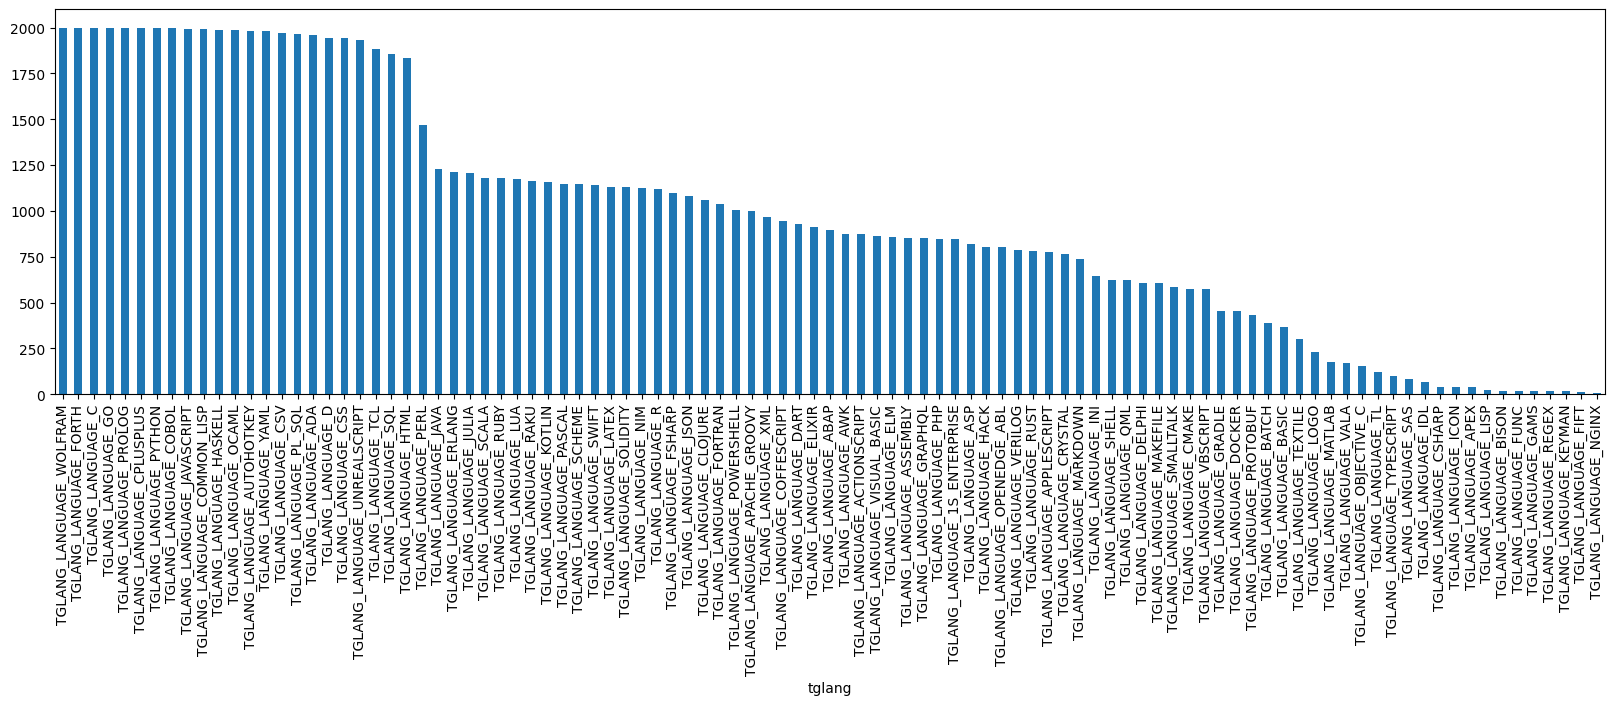

In [68]:
def custom_sampling(group):
    k = 2000

    if group.shape[0] > k:
        return group.sample(n=k, random_state=137, replace=False)
    return group.sample(n=k, random_state=137, replace=True)

snippets_smapled = snippets[snippets["code"] != ""]
snippets_smapled = snippets_smapled\
    .groupby(["tglang", "target"])\
    .apply(custom_sampling)\
    .drop_duplicates()

snippets_smapled["tglang"].value_counts().plot(kind='bar', figsize = (20,5))

In [70]:
snippets_smapled.shape

(96753, 3)

In [80]:
for row_idx, row in snippets_smapled.sample(n = 3).iterrows():
    print("=-=-==-=-=-=-==-=-=-=-=-=-=-=")
    print(row["code"])

=-=-==-=-=-=-==-=-=-=-=-=-=-=
interrogateurs -0.335237 0.117214 0.171001 -0.407725 0.345174 0.577302 -0.170898 0.011104 -0.025912 -0.219108 0.282428 -0.003777 -0.482978 0.008953 -0.514473 -0.054928 -0.195484 -0.248611 -0.216481 -0.329799 -0.247059 0.063188 -0.097865 0.032178 0.108171 0.102064 0.007805 -0.151710 0.439864 -0.093964 -0.017044 -0.583625 -0.406591 0.523417 -0.388209 -0.191340 0.224517 0.151282 0.124668 0.004901 0.290866 -0.473543 -0.424262 0.027228 0.068860 -0.011260 0.906863 -0.528064 -0.044414 -0.718104 
glanées -0.248239 0.666959 0.207064 0.105795 -0.247287 0.516823 0.125107 -0.124993 -0.334005 -0.333624 -0.138000 0.130614 -0.614546 -0.507290 -0.565199 -0.664503 -0.280438 0.064804 0.113878 0.135959 0.259408 0.077302 0.348764 -0.091667 -0.296618 -0.565010 0.089460 -0.073017 0.088782 0.397104 -0.073171 -0.397621 -0.121357 -0.200169 -0.448885 -0.265312 -0.107110 -0.189941 0.160885 0.336833 0.302398 0.015645 -0.515219 -0.045297 -0.163657 0.174319 0.556108 -0.125123 0.347275 

In [89]:
import re

example = """
package main
import "fmt"
import "regexp"
 
func main() {
  str := "I am the original string"
 
  // Test
  matched, _ := regexp.MatchString(".*string$", str)
  if matched { fmt.Println("ends with 'string'") }
 
  // Substitute
  pattern := regexp.MustCompile("original")
  result := pattern.ReplaceAllString(str, "modified")
  fmt.Println(result)
}
"""

"".join(re.split(
    r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])""",
    example
))

'\npackage main\nimport "fmt"\nimport "regexp"\n \nfunc main() {\n  str := "I am the original string"\n \n  // Test\n  matched, _ := regexp.MatchString(".*string$", str)\n  if matched { fmt.Println("ends with \'string\'") }\n \n  // Substitute\n  pattern := regexp.MustCompile("original")\n  result := pattern.ReplaceAllString(str, "modified")\n  fmt.Println(result)\n}\n'

In [103]:
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier

sgd = SGDClassifier(loss="log_loss")
svc = LinearSVC()

from sklearn.metrics import accuracy_score,hamming_loss,precision_score,recall_score,f1_score
def print_metrics_report(clf,y_test,y_pred):
    print("Clf: ", clf.__class__.__name__)
    print('Exact Match Ratio: {0}'.format(np.round(accuracy_score(y_test, y_pred, normalize=True, sample_weight=None)*100,2)))
    print('Accuracy: {0}'.format(accuracy_score(y_test, y_pred)))
    print('Hamming loss: {0}'.format(np.round(hamming_loss(y_test, y_pred)*100,2))) 
    print('Recall: {0}'.format(np.round(precision_score(y_test, y_pred, average='micro')*100,2)))
    print('Precision: {0}'.format(np.round(recall_score(y_test,y_pred, average='micro')*100,2)))
    print('F1 Measure: {0}'.format(np.round(f1_score(y_test, y_pred, average='micro')*100,2))) 
    print('-------------')
    print("")

In [112]:
token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

def preprocess(x):
    return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

def preprocess_2(x):
    return pd.Series(x).apply(
        lambda x: "".join(
            re.split(
                r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])""",
                x
            )
        )
    )

snippets_processed = snippets_smapled.copy()
snippets_processed["code"] = preprocess(snippets_processed["code"])
print("preprocess done..")
# snippets_processed["code"] = preprocess_2(snippets_processed["code"])
# print("preprocess preprocess_2..")

preprocess done..


In [113]:
snippets_processed.head(3)

code  \
tglang                        target                                                             
TGLANG_LANGUAGE_1S_ENTERPRISE 1      249845  \tЕсли ПустаяСтрока(КодОшибки) Тогда \n\t\tРез...   
                                     249402  Supported language versions:\npreview\ndefault...   
                                     249699      "-----------------------------------------...   

                                                                    tglang  \
tglang                        target                                         
TGLANG_LANGUAGE_1S_ENTERPRISE 1      249845  TGLANG_LANGUAGE_1S_ENTERPRISE   
                                     249402  TGLANG_LANGUAGE_1S_ENTERPRISE   
                                     249699  TGLANG_LANGUAGE_1S_ENTERPRISE   

                                             target  
tglang                        target                 
TGLANG_LANGUAGE_1S_ENTERPRISE 1      249845       1  
                                     249402       1  
                                     249699       1

In [126]:
"""
    Нужно поисграть с параметрами
"""

from sklearn.linear_model import LogisticRegression
token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

def preprocess(x):
    return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
        .replace(r'\b[A-Za-z]\b', '', regex=True)

# param_grid = [    
#     {
#         'logreg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#         'logreg__C' : np.logspace(-4, 4, 20),
#         'logreg__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#         'logreg__max_iter' : [100, 1000,2500, 5000]
#     }
# ]

param_grid = [    
    {
        'logreg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
        # 'logreg__C' : np.logspace(-4, 4, 20),
        'logreg__solver' : ['liblinear', 'saga'],
        'logreg__max_iter' : [100]
    }
]

from sklearn.model_selection import GridSearchCV

logModel = LogisticRegression()

transformer = FunctionTransformer(preprocess)
vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)

pipe_RF = Pipeline([
    ('preprocessing', transformer),
    ('vectorizer', vectorizer),
    ('logreg', logModel)]
)

clf = GridSearchCV(pipe_RF,
                   param_grid=param_grid,
                   cv=4,
                   verbose=5,
                   n_jobs=-1)

X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(
    snippets_processed["code"],
    snippets_processed["target"], test_size=0.10, random_state=137)

best_clf = clf.fit(X_train_gs, y_train_gs)

Fitting 4 folds for each of 8 candidates, totalling 32 fits


/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/4] END logreg__max_iter=100, logreg__penalty=l1, logreg__solver=liblinear;, score=0.846 total time= 5.2min
[CV 3/4] END logreg__max_iter=100, logreg__penalty=l2, logreg__solver=liblinear;, score=0.799 total time= 5.1min
[CV 4/4] END logreg__max_iter=100, logreg__penalty=elasticnet, logreg__solver=liblinear;, score=nan total time=  59.2s


/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/line

[CV 1/4] END logreg__max_iter=100, logreg__penalty=l1, logreg__solver=liblinear;, score=0.847 total time= 5.1min
[CV 2/4] END logreg__max_iter=100, logreg__penalty=l2, logreg__solver=liblinear;, score=0.794 total time= 4.9min
[CV 1/4] END logreg__max_iter=100, logreg__penalty=elasticnet, logreg__solver=liblinear;, score=nan total time= 1.0min
[CV 1/4] END logreg__max_iter=100, logreg__penalty=elasticnet, logreg__solver=saga;, score=nan total time=  58.0s
[CV 3/4] END logreg__max_iter=100, logreg__penalty=l1, logreg__solver=liblinear;, score=0.847 total time= 5.1min
[CV 1/4] END logreg__max_iter=100, logreg__penalty=l2, logreg__solver=liblinear;, score=0.798 total time= 5.1min
[CV 3/4] END logreg__max_iter=100, logreg__penalty=elasticnet, logreg__solver=liblinear;, score=nan total time= 1.1min
[CV 3/4] END logreg__max_iter=100, logreg__penalty=elasticnet, logreg__solver=saga;, score=nan total time= 1.0min
[CV 1/4] END logreg__max_iter=100, logreg__penalty=l1, logreg__solver=saga;, score

/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. T

[CV 4/4] END logreg__max_iter=100, logreg__penalty=l1, logreg__solver=saga;, score=0.852 total time= 7.3min
[CV 4/4] END logreg__max_iter=100, logreg__penalty=l2, logreg__solver=saga;, score=0.797 total time= 4.8min
[CV 1/4] END logreg__max_iter=100, logreg__penalty=none, logreg__solver=saga;, score=0.909 total time= 3.2min


/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
12 fits failed out of a total of 32.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
4 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-

[CV 1/4] END logreg__max_iter=100, logreg__penalty=none, logreg__solver=liblinear;, score=nan total time=  57.0s


/Users/platon.fedorov/opt/anaconda3/envs/tgml/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [129]:
best_clf.best_estimator_

Pipeline(steps=[('preprocessing',
                 FunctionTransformer(func=<function preprocess at 0x7febc8a64c10>)),
                ('vectorizer',
                 TfidfVectorizer(max_features=3000,
                                 token_pattern='(\\b[A-Za-z_]\\w*\\b|[!\\#\\$%\\&\\*\\+:\\-\\./<=>\\?@\\\\\\^_\\|\\~]+|[ '
                                               '\\t\\(\\),;\\{\\}\\[\\]`"\'])')),
                ('logreg', LogisticRegression(penalty='none', solver='saga'))])

In [130]:
print(f'Accuracy: {best_clf.score(X_test_gs, y_test_gs)}')

Accuracy: 0.9090533278214138


In [ ]:
# from sklearn.datasets import make_classification
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.experimental import enable_halving_search_cv  # noqa
# from sklearn.model_selection import HalvingGridSearchCV

# param_grid = [    
#     {
#         'logreg__penalty' : ['l1', 'l2', 'elasticnet', 'none'],
#         # 'logreg__C' : np.logspace(-4, 4, 20),
#         'logreg__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
#         'logreg__max_iter' : [100]
#     }
# ]

# from sklearn.linear_model import LogisticRegression
# token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

# def preprocess(x):
#     return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
#         .replace(r'\b[A-Za-z]\b', '', regex=True)

# from sklearn.feature_extraction.text import TfidfVectorizer

# vectorizer = TfidfVectorizer(
#     token_pattern=token_pattern,
#     max_features=3000)

# X_train_val, X_test, y_train_val, y_test = train_test_split(
#     snippets_processed["code"],
#     snippets_processed["target"], test_size=0.10, random_state=137)
# print("TrainVal / Test split done..")

# X_train, X_val, y_train, y_val = train_test_split(
#     X_train_val,
#     y_train_val, test_size=0.10, random_state=137)
# print("Train / Val split done..")

# X_train = preprocess(X_train)
# X_val   = preprocess(X_val)
# X_test  = preprocess(X_test)
# print("Processing done..")

# vectorizer.fit(X_train)
# print("Fit vectorizer done..")

# X_train = vectorizer.predict(X_train)
# X_val   = vectorizer.predict(X_val)
# X_test  = vectorizer.predict(X_test)
# print("Vectorization done..")

# from sklearn.model_selection import GridSearchCV

# logreg = LogisticRegression()
# logreg_cv = GridSearchCV(
#     logreg,
#     param_grid,
#     cv=10
# )
# logreg_cv.fit(x_train, y_train)

# print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
# print("accuracy :",logreg_cv.best_score_)

In [106]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# tfidf = TfidfVectorizer(
#     max_features=3000,
#     ngram_range=(1),
#     token_pattern=token_pattern
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     snippets_processed["code"],
#     snippets_processed["target"], test_size=0.10, random_state=137)
# print("Split done..")

# tfidf = tfidf.fit(X_train)
# print("Train done..")

# X_train = tfidf.transform(X_train)
# X_test  = tfidf.transform(X_test)

# X_train.shape, X_test.shape

Split done..
Train done..


((87077, 25000), (9676, 25000))

In [107]:
# for classifier in [sgd]:
#     clf = OneVsRestClassifier(classifier)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test)
#     print_metrics_report(classifier,y_test,y_pred)

Clf:  SGDClassifier
Exact Match Ratio: 77.85
Accuracy: 0.7785241835469202
Hamming loss: 22.15
Recall: 77.85
Precision: 77.85
F1 Measure: 77.85
-------------



In [ ]:
# ngram_range=(1, 3) 78%

In [27]:
# model_0 = clf.estimators_[0]
# model_0.n_features_in_, model_0.coef_

(43348,
 array([[ 0.16673093, -0.01976526, -0.06637467, ...,  0.        ,
          0.        ,  0.        ]]))

In [110]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.preprocessing import FunctionTransformer
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestClassifier
# from sklearn.pipeline import Pipeline

# token_pattern = r"""(\b[A-Za-z_]\w*\b|[!\#\$%\&\*\+:\-\./<=>\?@\\\^_\|\~]+|[ \t\(\),;\{\}\[\]`"'])"""

# def preprocess(x):
#     return pd.Series(x).replace(r'\b([A-Za-z])\1+\b', '', regex=True)\
#         .replace(r'\b[A-Za-z]\b', '', regex=True)

# # Pipe steps
# transformer = FunctionTransformer(preprocess)
# vectorizer = TfidfVectorizer(token_pattern=token_pattern, max_features=3000)
# clf = RandomForestClassifier(n_jobs=4)

# pipe_RF = Pipeline([
#     ('preprocessing', transformer),
#     ('vectorizer', vectorizer),
#     ('clf', clf)]
# )

# # Setting best params
# best_params = {
#     'clf__criterion': 'gini',
#     'clf__max_features': 'sqrt',
#     'clf__min_samples_split': 3,
#     'clf__n_estimators': 300
# }

# pipe_RF.set_params(**best_params)

# X_train_, X_test_, y_train_, y_test_ = train_test_split(
#     snippets_processed["code"],
#     snippets_processed["target"],
#     test_size=0.2)

# # Fitting
# pipe_RF.fit(X_train_, y_train_)

# # Evaluation
# print(f'Accuracy: {pipe_RF.score(X_test_, y_test_)}')

Accuracy: 0.9277556715415224
